<a href="https://colab.research.google.com/github/micah-shull/Machine_Learning_Pipelines/blob/main/pipelines_01_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Why Perform Feature Selection Using Pipelines?

**Feature selection** is the process of selecting a subset of relevant features for use in model construction. Integrating feature selection within a pipeline offers several benefits:

1. **Consistency and Reproducibility**:
   - By including feature selection in the pipeline, you ensure that the same selection process is applied consistently across different stages of model development (training, validation, testing).
   - This reproducibility is crucial when moving from development to production, as the same steps will be applied without manual intervention.

2. **Simplified Workflow**:
   - Pipelines encapsulate the entire workflow, reducing the complexity of the code and making it more maintainable.
   - This simplification helps in debugging and makes the process easier to understand and document.

3. **Avoid Data Leakage**:
   - Data leakage occurs when information from outside the training dataset is used to create the model, leading to overly optimistic performance estimates.
   - By using a pipeline, you can ensure that feature selection is performed on the training data alone, preventing leakage of test data information into the training process.

4. **Automated Hyperparameter Tuning**:
   - When you use pipelines, you can easily integrate hyperparameter tuning (e.g., using `GridSearchCV` or `RandomizedSearchCV`) to select the best parameters for both feature selection and the model.
   - This integration allows for a more comprehensive search of the best configuration, optimizing both the preprocessing and model training stages simultaneously.

5. **Modularity and Reusability**:
   - Pipelines make it easy to modify or extend your workflow. For example, you can switch out the feature selection method or add new preprocessing steps with minimal changes to the overall structure.
   - This modularity is beneficial when experimenting with different models or preprocessing techniques.

### Why Use a Pipeline Instead of Doing It Manually?

**Manual Feature Selection**:
- **Error-Prone**: Manually applying feature selection can lead to inconsistencies and errors, especially in complex workflows.
- **Time-Consuming**: Requires more effort to ensure that the same steps are applied consistently across different datasets (training, validation, testing).
- **Less Reproducible**: Manual processes are harder to document and reproduce, leading to potential issues when transitioning from development to production.

**Using Pipelines**:
- **Automated Workflow**: Encapsulates the entire process, from preprocessing to feature selection to model training, into a single, cohesive workflow.
- **Consistent Application**: Ensures that all steps are applied in a consistent manner, reducing the risk of errors and improving reproducibility.
- **Ease of Use**: Simplifies the experimentation process, making it easy to swap out or modify different components of the workflow.
- **Integrated Hyperparameter Tuning**: Allows for comprehensive optimization of both preprocessing and model training parameters in a unified framework.

### Example Benefits of Using a Pipeline for Feature Selection

1. **Consistent Training and Evaluation**: Ensures that feature selection is applied consistently during cross-validation, avoiding data leakage and providing a more accurate estimate of model performance.
2. **Simplified Code**: Reduces boilerplate code and the potential for bugs by encapsulating feature selection within the pipeline.
3. **Efficient Hyperparameter Tuning**: Facilitates the optimization of feature selection parameters alongside model parameters, leading to better overall performance.

By leveraging pipelines for feature selection, you gain a more robust, maintainable, and scalable approach to building and evaluating machine learning models.

### Load the Diabetes Data

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns


# Load the Diabetes dataset
diabetes = load_diabetes(as_frame=True)
df = diabetes.frame

# Convert the target to binary (median split for binary classification)
df['target_binary'] = (df['target'] > df['target'].median()).astype(int)

# Define features (X) and target (y)
X = df.drop(columns=['target', 'target_binary'])  # Drop the original continuous target and binary target
y = df['target_binary']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the first few rows of the training data
print("Training Data:")
print(X_train.info())

# Display the shape of the dataset
print(f"\nNumber of Features: {X_train.shape[1]}")
print(f"Number of Training Samples: {X_train.shape[0]}")
print(f"Number of Testing Samples: {X_test.shape[0]}")


Training Data:
<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 17 to 102
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     353 non-null    float64
 1   sex     353 non-null    float64
 2   bmi     353 non-null    float64
 3   bp      353 non-null    float64
 4   s1      353 non-null    float64
 5   s2      353 non-null    float64
 6   s3      353 non-null    float64
 7   s4      353 non-null    float64
 8   s5      353 non-null    float64
 9   s6      353 non-null    float64
dtypes: float64(10)
memory usage: 30.3 KB
None

Number of Features: 10
Number of Training Samples: 353
Number of Testing Samples: 89


### **Establishing a Baseline Model**

1. **Purpose of a Baseline Model**:
   - The baseline model uses all features in the dataset without applying any feature selection. This helps us understand the model’s performance when using all available information.
   - It serves as a reference point to evaluate the effectiveness of `SelectKBest` in improving model performance.

2. **Pipeline Without Feature Selection**:
   - **Preprocessing**:
     - Missing values in numeric columns are filled with the median using `SimpleImputer`.
     - Numeric features are standardized using `StandardScaler` to ensure all features are on a similar scale.
   - **Classifier**:
     - We use `LogisticRegression` for classification due to its simplicity and interpretability.

3. **Metrics**:
   - **Classification Report**:
     - Precision, Recall, F1-Score, and Accuracy are displayed for each class.
   - **Cross-Validation**:
     - A 5-fold cross-validation is performed to estimate the model’s generalization performance.

4. **Outcome**:
   - The baseline model results (accuracy, precision, recall, F1-score) will be stored to compare against the `SelectKBest` model.



In [4]:
# Define the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())  # Standardize the numeric features
])

# Apply the preprocessing pipeline to all numeric columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)  # Transform numeric features
])

# Create a pipeline without feature selection
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression
])

# Train the baseline model
baseline_pipeline.fit(X_train, y_train)

# Predict on the test set
baseline_y_pred = baseline_pipeline.predict(X_test)

# Save and display the classification report
baseline_report = classification_report(y_test, baseline_y_pred, output_dict=True)
print("Baseline Model Classification Report:")
print(classification_report(y_test, baseline_y_pred))

# Cross-validation scores for baseline model
baseline_cv_scores = cross_val_score(baseline_pipeline, X_train, y_train, cv=5)
print("Baseline Cross-validation scores: ", baseline_cv_scores)
print("Baseline Mean cross-validation score: ", baseline_cv_scores.mean())


Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        49
           1       0.69      0.72      0.71        40

    accuracy                           0.73        89
   macro avg       0.73      0.73      0.73        89
weighted avg       0.73      0.73      0.73        89

Baseline Cross-validation scores:  [0.84507042 0.74647887 0.70422535 0.68571429 0.71428571]
Baseline Mean cross-validation score:  0.7391549295774649


##Using SelectKBest for Feature Selection

#### **What is `SelectKBest`?**
`SelectKBest` is a feature selection method provided by scikit-learn that selects the top `k` features from your dataset based on a specified statistical test. It is part of the `sklearn.feature_selection` module and is often used in preprocessing steps to reduce the dimensionality of the data.

#### **How Does `SelectKBest` Work?**
1. **Scoring Function**: `SelectKBest` relies on a scoring function (e.g., `f_classif`, `chi2`, `mutual_info_classif`) to rank the features based on their importance or relevance.
2. **Top `k` Features**: After ranking, it selects the top `k` features with the highest scores, where `k` is specified by the user.
3. **Feature Subset**: It outputs a reduced dataset containing only the selected features.

The statistical test you use depends on the nature of your problem:
- For classification problems: `f_classif`, `chi2`, or `mutual_info_classif`.
- For regression problems: `f_regression` or `mutual_info_regression`.

#### **Why is `SelectKBest` Useful?**
Feature selection is a crucial preprocessing step in machine learning for several reasons:
1. **Dimensionality Reduction**: It reduces the number of input features, which can decrease model complexity and improve computational efficiency.
2. **Improved Model Performance**: By removing irrelevant or redundant features, the model may generalize better to unseen data.
3. **Reduced Risk of Overfitting**: Irrelevant features can introduce noise, which may lead to overfitting. Selecting only the most relevant features mitigates this risk.
4. **Faster Training**: Fewer features mean the model trains faster and requires fewer resources.
5. **Interpretability**: It improves the interpretability of the model by focusing on the most important features.

#### **Using `SelectKBest` in Pipelines**
When used in an `sklearn.pipeline.Pipeline`, `SelectKBest` becomes a powerful tool for automating feature selection as part of the model training workflow. This ensures that feature selection is:
1. **Consistently Applied**: It integrates feature selection into the training and testing steps, ensuring that the same features are selected during cross-validation and parameter tuning.
2. **Reproducible**: Pipelines standardize workflows, making them more reproducible.
3. **Prevents Data Leakage**: By applying feature selection within the pipeline, you ensure that the test data is not used during the feature selection process.


### Key Parameters of `SelectKBest`
- **`score_func`**: The statistical test to evaluate feature importance. Common options:
  - `f_classif`: ANOVA F-value between label/feature for classification tasks.
  - `chi2`: Chi-squared test for non-negative features.
  - `mutual_info_classif`: Mutual information for classification.
- **`k`**: The number of top features to select. If `k='all'`, all features are kept.

### Key Attributes
- **`scores_`**: The scores of all features.
- **`pvalues_`**: The p-values of the scores (if available from the scoring function).

#### **When to Use `SelectKBest`**
- When you want a quick, statistically-grounded method to reduce features.
- When you suspect that not all features are relevant to the task.
- When you are working with high-dimensional data and want to simplify the model.



In [5]:
# Create a pipeline with SelectKBest
selectkbest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Use the same preprocessing
    ('feature_selection', SelectKBest(score_func=f_classif, k=3)),  # Select top 5 features
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression
])

# Train the SelectKBest model
selectkbest_pipeline.fit(X_train, y_train)

# Predict on the test set
selectkbest_y_pred = selectkbest_pipeline.predict(X_test)

# Save and display the classification report
selectkbest_report = classification_report(y_test, selectkbest_y_pred, output_dict=True)
print("\nSelectKBest Model Classification Report:")
print(classification_report(y_test, selectkbest_y_pred))

# Cross-validation scores for SelectKBest model
selectkbest_cv_scores = cross_val_score(selectkbest_pipeline, X_train, y_train, cv=5)
print("SelectKBest Cross-validation scores: ", selectkbest_cv_scores)
print("SelectKBest Mean cross-validation score: ", selectkbest_cv_scores.mean())



SelectKBest Model Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        49
           1       0.72      0.72      0.72        40

    accuracy                           0.75        89
   macro avg       0.75      0.75      0.75        89
weighted avg       0.75      0.75      0.75        89

SelectKBest Cross-validation scores:  [0.8028169  0.74647887 0.69014085 0.71428571 0.71428571]
SelectKBest Mean cross-validation score:  0.7336016096579477


### Comparing the Baseline and SelectKBest Models
We will now compare the metrics of the Baseline Model and the SelectKBest Model side by side. To make the comparison more insightful, we’ll also visualize the results using a bar chart.

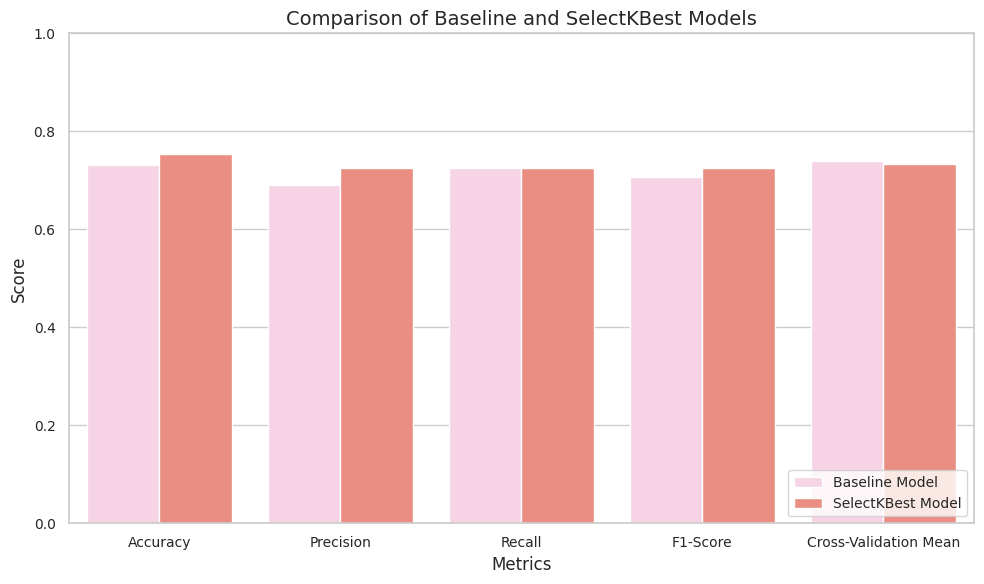

In [12]:
# Create a DataFrame to compare performance
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "Cross-Validation Mean"],
    "Baseline Model": [
        baseline_report["accuracy"],
        baseline_report["1"]["precision"],
        baseline_report["1"]["recall"],
        baseline_report["1"]["f1-score"],
        baseline_cv_scores.mean()
    ],
    "SelectKBest Model": [
        selectkbest_report["accuracy"],
        selectkbest_report["1"]["precision"],
        selectkbest_report["1"]["recall"],
        selectkbest_report["1"]["f1-score"],
        selectkbest_cv_scores.mean()
    ]
})

# Set Seaborn theme and style
sns.set_theme(style="whitegrid", context="notebook")  # Choose a clean grid style for clarity

# Melt the data for a grouped bar chart
comparison_melted = comparison.melt(id_vars="Metric", var_name="Model", value_name="Score")

# Create the bar chart with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=comparison_melted,
    x="Metric",
    y="Score",
    hue="Model",
    palette="Set3_r"  # Use a visually distinct palette
)

# Add chart details
plt.title("Comparison of Baseline and SelectKBest Models", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.ylim(0, 1)  # Ensure the y-axis ranges from 0 to 1
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()


In [8]:
# Display the comparison table
print("\nComparison of Baseline and SelectKBest Models:")
print(comparison)


Comparison of Baseline and SelectKBest Models:
                  Metric  Baseline Model  SelectKBest Model
0               Accuracy        0.730337           0.752809
1              Precision        0.690476           0.725000
2                 Recall        0.725000           0.725000
3               F1-Score        0.707317           0.725000
4  Cross-Validation Mean        0.739155           0.733602


### **Feature Importance and the Plot Explanation**

#### **What is Feature Importance?**
Feature importance quantifies how relevant each feature is to predicting the target variable. In the context of `SelectKBest` and the F-Score:
- The **F-Score** is a statistical measure derived from the ANOVA F-test.
- It evaluates the variance between feature groups (based on the target) compared to the variance within groups.
- Features with a **higher F-Score** have stronger relationships with the target and are deemed more important.

---

#### **What Does the Plot Show?**
1. **Features Selected**:
   - The plot shows the top features selected by `SelectKBest`, ranked by their F-Scores. These are the features the model deemed most relevant to predicting the target.

2. **Feature Rankings**:
   - Features are sorted by their F-Score in ascending order to make it visually clear which features are more important.
   - For example:
     - `num__MedInc` (Median Income) has the **highest F-Score** (6203.97), indicating it has the strongest relationship with the target.
     - `num__AveBedrms` (Average Bedrooms) has the **lowest F-Score** (65.84) among the selected features, making it the least important of the top 5.

3. **Interpreting the F-Scores**:
   - **High F-Scores**: Features like `num__MedInc` and `num__Latitude` have a stronger linear relationship with the target, making them key predictors.
   - **Low F-Scores**: Features like `num__AveBedrms` and `num__HouseAge` still contribute but with less significance.

4. **Axis Interpretation**:
   - **X-axis (F-Score)**: The strength of the relationship between each feature and the target.
   - **Y-axis (Features)**: Names of the top features selected after preprocessing.

---

#### **Summary of Your Example**
- The plot shows that **Median Income (`num__MedInc`)** is by far the most important feature for predicting the target.
- **Latitude (`num__Latitude`)** and **Average Rooms (`num__AveRooms`)** are also significant contributors, but less so than `Median Income`.
- **Average Bedrooms (`num__AveBedrms`)** and **House Age (`num__HouseAge`)** contribute the least among the top 5.

---

### **Why Is This Useful?**
1. **Model Simplification**: Knowing the most important features helps reduce dimensionality, focusing only on what matters most.
2. **Data Insights**:
   - High F-Scores suggest that features like `Median Income` and `Latitude` are key determinants for the target.
   - Low F-Scores suggest weaker predictive power.
3. **Feature Engineering**: This analysis may inspire further exploration, such as creating new features or refining existing ones.


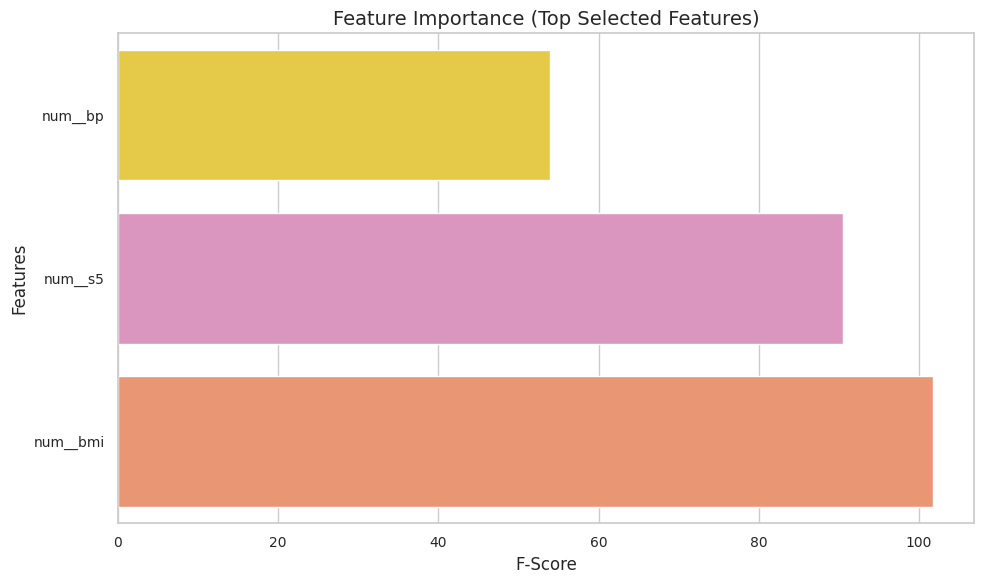

In [11]:
# Get the transformed feature names from the preprocessor
preprocessed_feature_names = selectkbest_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extract the feature scores and boolean mask for selected features
feature_scores = selectkbest_pipeline.named_steps['feature_selection'].scores_
selected_mask = selectkbest_pipeline.named_steps['feature_selection'].get_support()

# Use the preprocessed feature names for the selected features
selected_features = preprocessed_feature_names[selected_mask]

# Save the data to a DataFrame for easy manipulation
feature_importance_df = pd.DataFrame({
    "Feature": selected_features,
    "F-Score": feature_scores[selected_mask]
}).sort_values(by="F-Score", ascending=True)  # Sort for better visualization

# Set Seaborn theme and style
sns.set_theme(style="whitegrid", context="notebook")

# Create a horizontal bar plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df,
    x="F-Score",
    y="Feature",
    hue='Feature', palette="Set2_r"  # Use a categorical palette
)

# Add chart details
plt.title("Feature Importance (Top Selected Features)", fontsize=14)
plt.xlabel("F-Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [10]:
feature_importance_df

,Feature,F-Score
1,num__bp,53.974410
2,num__s5,90.570693
0,num__bmi,101.798120


### Correlation Heatmap (Before and After Feature Selection)
A heatmap helps visualize feature correlations, highlighting redundancy or relationships between features.

Correlation plots, such as heatmaps, provide insights into how strongly features are related to one another and to the target variable. Here's a detailed explanation of what the correlation plots reveal:

---

### **What Do Correlation Plots Show?**
1. **Strength and Direction of Relationships**:
   - **Values range from -1 to 1**:
     - **1**: Perfect positive correlation (as one feature increases, the other increases proportionally).
     - **-1**: Perfect negative correlation (as one feature increases, the other decreases proportionally).
     - **0**: No linear relationship.
   - The strength and direction of correlations help identify the degree of linear association between variables.

2. **Redundancy in Features**:
   - Highly correlated features (e.g., correlation close to 1 or -1) suggest redundancy. Including both in the model may not add value, as they provide overlapping information.
   - Feature selection methods, like `SelectKBest`, aim to eliminate such redundant features to improve model efficiency and reduce overfitting.

3. **Relationships with the Target**:
   - Features with strong correlations (positive or negative) to the target are likely to be more predictive.
   - Weakly correlated features might add noise and decrease model performance.

---

### **Insights from the Correlation Plots in This Example**
#### **Before Feature Selection**
- **Identify Redundant Features**:
  - Some features might have very high correlations with each other (e.g., >0.8 or <-0.8), indicating redundancy. Removing one of the features could simplify the model without losing much information.
- **Overall Structure**:
  - The heatmap shows which groups of features are related and helps you understand the dataset better.

#### **After Feature Selection**
- **Reduced Redundancy**:
  - The correlation heatmap of the selected features should show fewer strong correlations between features, as `SelectKBest` would ideally have removed redundant ones.
  - Features selected by `SelectKBest` are chosen for their individual predictive power relative to the target variable, not their correlations with other features.
  
- **Focus on Predictive Features**:
  - Features in this heatmap are the most relevant to the target, with stronger correlations expected.

---

### **How to Use This Information**
1. **Remove Highly Correlated Features**:
   - If you observe that two features are very highly correlated, consider dropping one of them unless both have distinct relationships with the target.
2. **Understand the Data**:
   - Heatmaps can highlight clusters of related features, helping you interpret the structure of the data.
3. **Validate Feature Selection**:
   - After feature selection, ensure the remaining features are meaningful and less redundant.
4. **Potential for Feature Engineering**:
   - If features are strongly correlated, you might consider combining them into a single new feature (e.g., their ratio, sum, or difference).

---

### Example Interpretations
#### **Before Feature Selection**:
- Feature A and Feature B are highly correlated (correlation = 0.95). Including both may not add value and might increase multicollinearity in your model.
- Feature C has almost no correlation with the target (correlation = 0.01). It’s unlikely to be helpful for the model.

#### **After Feature Selection**:
- The remaining features have weaker inter-correlations but stronger correlations with the target, which means they are more likely to contribute uniquely to model performance.





###Before Feature Selection

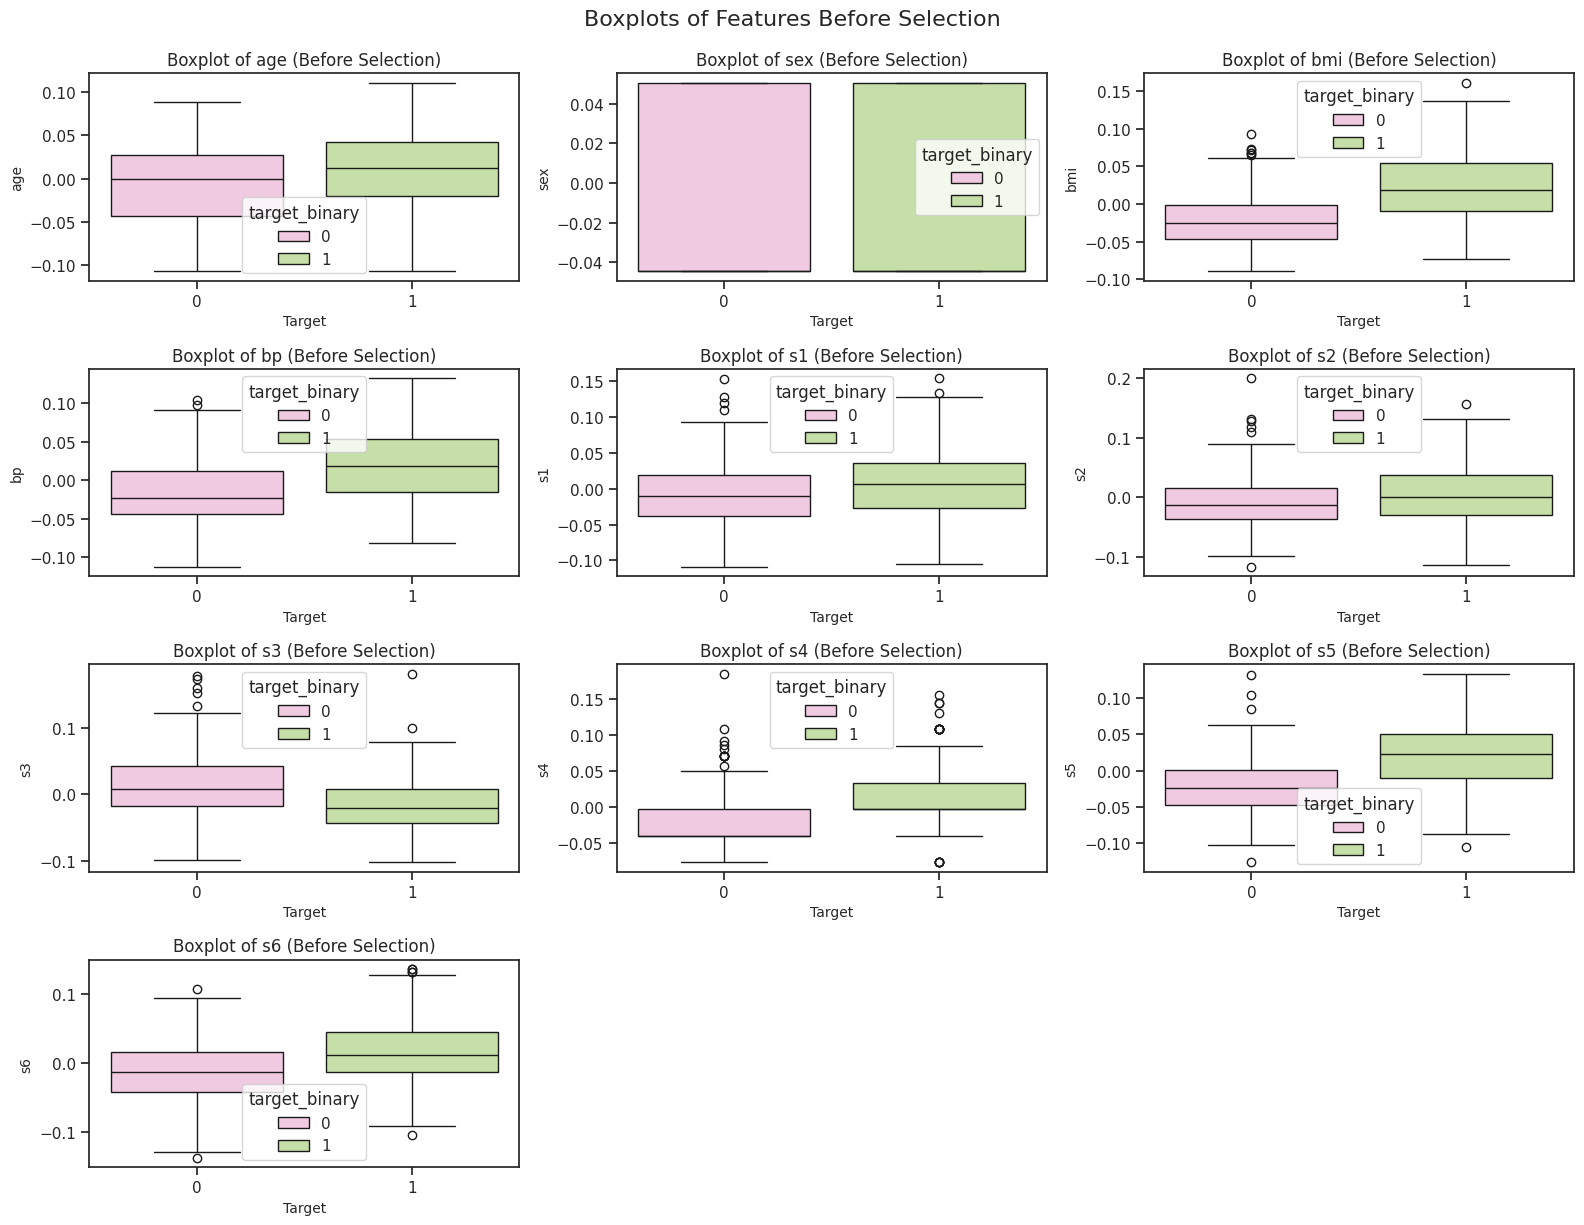

In [13]:
sns.set_theme(style="ticks", context="notebook")

# Plot boxplots before feature selection
plt.figure(figsize=(16, 12))
# numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns - 'sex'

for i, feature in enumerate(numeric_features, 1):
    plt.subplot((len(numeric_features) + 2) // 3, 3, i)  # Dynamically calculate rows and columns
    sns.boxplot(x=y_train, y=X_train[feature], hue=y_train, palette="PiYG", linecolor='k')
    plt.title(f"Boxplot of {feature} (Before Selection)", fontsize=12)
    plt.xlabel("Target", fontsize=10)
    plt.ylabel(feature, fontsize=10)

plt.tight_layout()
plt.suptitle("Boxplots of Features Before Selection", fontsize=16, y=1.02)
plt.show()

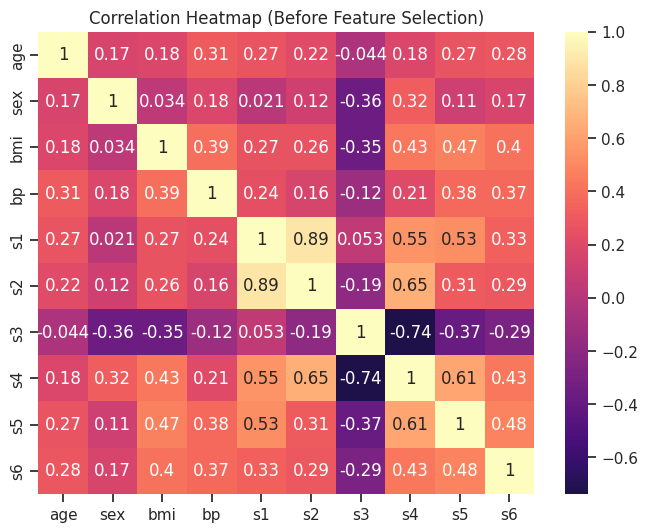

In [14]:
# Correlation heatmap of all features
plt.figure(figsize=(8, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='magma', center=0)
plt.title('Correlation Heatmap (Before Feature Selection)')
plt.show()

###After Feature Selection

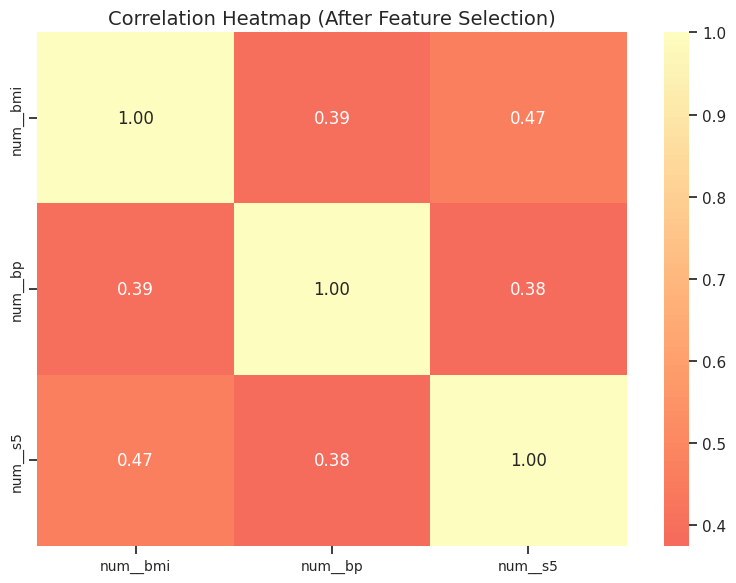

In [15]:
# Transform the training data using the pipeline
X_train_transformed = selectkbest_pipeline.named_steps['preprocessor'].transform(X_train)

# Convert the transformed data into a DataFrame with proper feature names
transformed_feature_names = selectkbest_pipeline.named_steps['preprocessor'].get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)

# Filter the transformed DataFrame to include only the selected features
selected_X_train = X_train_transformed_df[selected_features]

# Plot the correlation heatmap of selected features
plt.figure(figsize=(8, 6))
sns.heatmap(selected_X_train.corr(), annot=True, cmap='magma', center=0, fmt=".2f", cbar=True)
plt.title('Correlation Heatmap (After Feature Selection)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


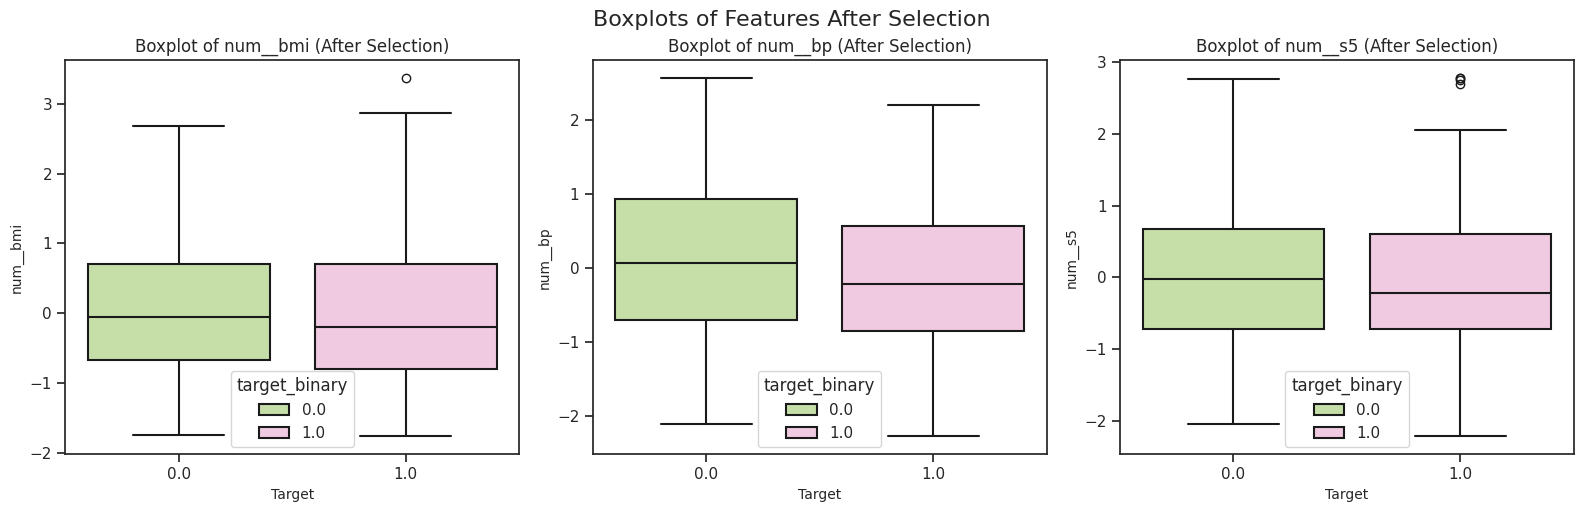

In [17]:
sns.set_theme(style="ticks", context="notebook")

# Transform the training data using the pipeline
X_train_transformed = selectkbest_pipeline.named_steps['preprocessor'].transform(X_train)

# Convert the transformed data into a DataFrame with proper feature names
transformed_feature_names = selectkbest_pipeline.named_steps['preprocessor'].get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)

# Filter the transformed data to include only the selected features
selected_X_train = X_train_transformed_df[selected_features]

# Plot boxplots for selected features
plt.figure(figsize=(16, 5))
for i, feature in enumerate(selected_features, 1):
    plt.subplot((len(selected_features) + 2) // 3, 3, i)  # Dynamically calculate rows and columns
    sns.boxplot(x=y_train, y=selected_X_train[feature], hue=y_train, palette="PiYG_r", linewidth=1.5, linecolor='k')
    plt.title(f"Boxplot of {feature} (After Selection)", fontsize=12)
    plt.xlabel("Target", fontsize=10)
    plt.ylabel(feature, fontsize=10)

plt.tight_layout()
plt.suptitle("Boxplots of Features After Selection", fontsize=16, y=1.02)
plt.show()


### Grid Search for Optimal K Value

From your results, here's a breakdown and interpretation:

---

### **Results**
| **k (Number of Features)** | **Mean CV Score** |
|----------------------------|-------------------|
| 3                          | 0.7336            |
| 5                          | 0.7449            |
| 7                          | 0.7449            |
| 10                         | 0.7392            |

---

### **Interpretation**
1. **Optimal `k`**:
   - The highest mean CV score is achieved with `k=5` and `k=7` (Mean CV Score = 0.7449).
   - Since both perform equally well, you can choose either value.
   - Typically, the smaller `k` is preferred (in this case, `k=5`) to reduce the model's complexity without sacrificing performance.

2. **Performance Trends**:
   - **Low `k` (3 features)**: The model performance is slightly lower (Mean CV Score = 0.7336), likely due to insufficient features to capture the full relationship with the target.
   - **High `k` (10 features)**: Performance slightly drops (Mean CV Score = 0.7392), which could indicate the inclusion of less relevant or noisy features.

3. **Plateau**:
   - The scores plateau between `k=5` and `k=7`, suggesting that adding more features beyond `k=5` does not add significant value.



3. **Visualize Performance**:
   - Use the plot already generated to explain the relationship between `k` and model performance in your notebook.

4. **Explain Findings**:
   - Highlight the importance of tuning `k` in feature selection to balance complexity and performance.



k=3, Mean CV Score: 0.7336
k=5, Mean CV Score: 0.7449
k=7, Mean CV Score: 0.7449
k=10, Mean CV Score: 0.7392


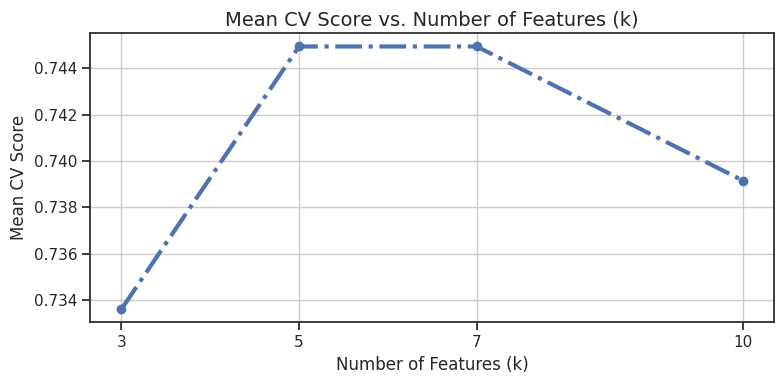

In [18]:
import matplotlib.pyplot as plt

# Store the results for different values of k
k_values = [3, 5, 7, 10]
cv_scores = []

# Perform cross-validation for each value of k
for k in k_values:
    selectkbest_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    scores = cross_val_score(selectkbest_pipeline, X_train, y_train, cv=5)
    mean_score = scores.mean()
    cv_scores.append(mean_score)
    print(f"k={k}, Mean CV Score: {mean_score:.4f}")

# Plot the results
plt.figure(figsize=(8,4))
plt.plot(k_values, cv_scores, marker='o', linestyle='-.', linewidth=3,color='b')
plt.title("Mean CV Score vs. Number of Features (k)", fontsize=14)
plt.xlabel("Number of Features (k)", fontsize=12)
plt.ylabel("Mean CV Score", fontsize=12)
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()


SelectKBest Model Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        49
           1       0.70      0.80      0.74        40

    accuracy                           0.75        89
   macro avg       0.75      0.76      0.75        89
weighted avg       0.76      0.75      0.75        89

SelectKBest Cross-validation scores: [0.83098592 0.74647887 0.69014085 0.7        0.75714286]
SelectKBest Mean Cross-validation score: 0.7449496981891348


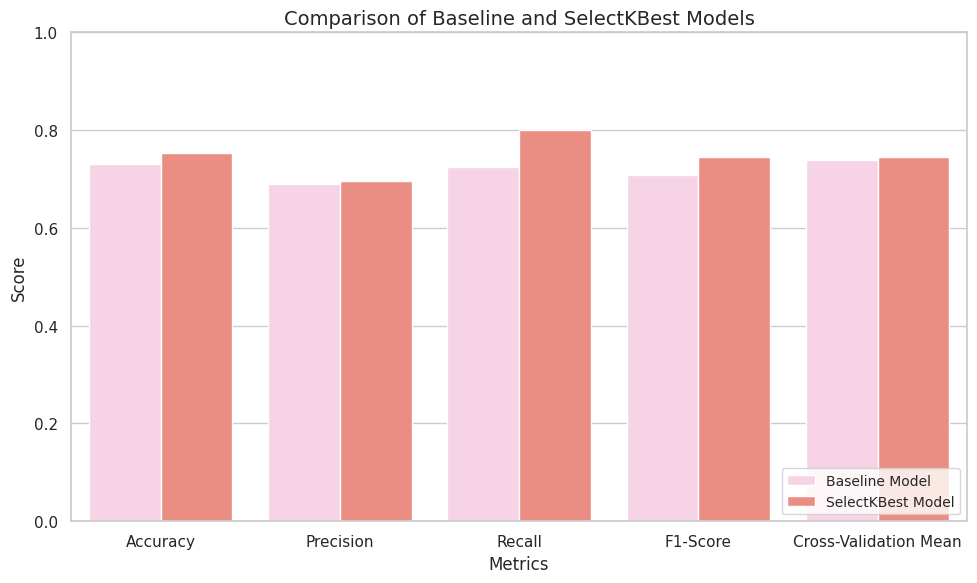

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import pandas as pd

# Define the final pipeline with k=5
selectkbest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step (scaling, imputation, etc.)
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),  # Select top 5 features
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression
])

# Train the final SelectKBest model
selectkbest_pipeline.fit(X_train, y_train)

# Predict on the test set
selectkbest_y_pred = selectkbest_pipeline.predict(X_test)

# Generate and display the classification report
selectkbest_report = classification_report(y_test, selectkbest_y_pred, output_dict=True)
print("SelectKBest Model Classification Report:")
print(classification_report(y_test, selectkbest_y_pred))

# Perform cross-validation
selectkbest_cv_scores = cross_val_score(selectkbest_pipeline, X_train, y_train, cv=5)
print("SelectKBest Cross-validation scores:", selectkbest_cv_scores)
print("SelectKBest Mean Cross-validation score:", selectkbest_cv_scores.mean())

# Compare to the baseline model
baseline_cv_scores_mean = baseline_cv_scores.mean()  # Baseline score from earlier
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "Cross-Validation Mean"],
    "Baseline Model": [
        baseline_report["accuracy"],
        baseline_report["1"]["precision"],
        baseline_report["1"]["recall"],
        baseline_report["1"]["f1-score"],
        baseline_cv_scores_mean
    ],
    "SelectKBest Model": [
        selectkbest_report["accuracy"],
        selectkbest_report["1"]["precision"],
        selectkbest_report["1"]["recall"],
        selectkbest_report["1"]["f1-score"],
        selectkbest_cv_scores.mean()
    ]
})


# Plot the comparison as a bar chart
sns.set_theme(style="whitegrid", context="notebook")
comparison_melted = comparison.melt(id_vars="Metric", var_name="Model", value_name="Score")
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x="Metric", y="Score", hue="Model", palette="Set3_r")
plt.title("Comparison of Baseline and SelectKBest Models", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.ylim(0, 1)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()


In [24]:
comparison['Baseline Model']
comparison['SelectKBest Model']

,Metric,Baseline Model,SelectKBest Model
0,Accuracy,0.730337,0.752809
1,Precision,0.690476,0.695652
2,Recall,0.725000,0.800000
3,F1-Score,0.707317,0.744186
4,Cross-Validation Mean,0.739155,0.744950


In [29]:
# Calculate the difference between the Baseline Model and SelectKBest Model
comparison['Difference'] = comparison['SelectKBest Model'] - comparison['Baseline Model']
comparison['% Change'] = (comparison['SelectKBest Model'] - comparison['Baseline Model'] )/comparison['Baseline Model'] * 100

# Display the updated comparison table
print("\nComparison of Baseline and SelectKBest Models:")
comparison



Comparison of Baseline and SelectKBest Models:


,Metric,Baseline Model,SelectKBest Model,Difference,% Change
0,Accuracy,0.730337,0.752809,0.022472,3.076923
1,Precision,0.690476,0.695652,0.005176,0.749625
2,Recall,0.725000,0.800000,0.075000,10.344828
3,F1-Score,0.707317,0.744186,0.036869,5.212510
4,Cross-Validation Mean,0.739155,0.744950,0.005795,0.783972


### **Interpreting the Results of the Final Model Comparison**




#### **Key Takeaways**

1. **Overall Improvement in Performance**:
   - The **SelectKBest model outperformed the baseline** across almost all metrics:
     - **Accuracy** improved from **73.03% to 75.28%** (+3.08%), reflecting higher overall prediction correctness.
     - **F1-Score** increased from **0.7073 to 0.7442** (+5.21%), demonstrating better balance between precision and recall.
     - The **Cross-Validation Mean** also saw a slight improvement (+0.78%), indicating more consistent performance during training.

2. **Precision**:
   - Precision increased marginally from **69.05% to 69.57%** (+0.75%).
   - This small improvement suggests the SelectKBest model was slightly better at avoiding false positives, maintaining stable performance while prioritizing recall.

3. **Recall**:
   - Recall saw the most **significant improvement**, increasing from **72.5% to 80.0%** (+10.34%).
   - Out of every 100 diabetic patients, the baseline model identified **72 cases**, while the SelectKBest model identified **80 cases**. This increase is critical in ensuring diabetic patients are flagged for further testing and treatment.

4. **Reduction in Complexity**:
   - The SelectKBest model achieved these improvements by using only the **top 5 features**, reducing model complexity.
   - This indicates that the removed features were likely irrelevant or noisy, leading to better generalization and efficiency.

---

#### **Why Recall Matters for Identifying Diabetes**
1. **Definition**:
   - Recall measures the proportion of actual positive cases (diabetes patients) that the model correctly identifies.
2. **Importance**:
   - **High recall** ensures that very few diabetic cases are missed, preventing undiagnosed conditions that could lead to severe health complications.
   - **False negatives** (missed diabetes cases) are more harmful than false positives, as they prevent early medical intervention.
3. **Impact**:
   - By increasing recall from **72.5% to 80.0%**, the SelectKBest model ensures more diabetic patients are identified, enabling timely treatment.

---

#### **Analysis of Key Metrics**

1. **Significant Increase in Recall (+10.34%)**:
   - Recall is the most critical metric in this context.
   - The SelectKBest model identifies **8 more diabetic patients per 100 cases** compared to the baseline.

2. **Minimal Impact on Precision (+0.75%)**:
   - Precision remains stable, meaning the proportion of correct positive predictions (true positives) out of all predicted positives did not degrade.

3. **Improved F1-Score (+5.21%)**:
   - The improved recall drives a higher F1-Score, making the SelectKBest model more effective at balancing false negatives and false positives.

---

### **Why the SelectKBest Model is Superior**

1. **Focus on the Most Relevant Features**:
   - By selecting the **top 5 features**, the SelectKBest model removed irrelevant or noisy variables, improving recall significantly without sacrificing precision.
   - This simplification enhances both interpretability and computational efficiency.

2. **Practical Implications**:
   - **Higher Recall**: Fewer missed diabetes cases mean more opportunities for early intervention.
   - **Manageable Precision Trade-off**: False positives (patients flagged as diabetic but aren’t) can be resolved with further medical testing.

---

### **Final Conclusion**

The **SelectKBest model** is better suited for diabetes prediction because:
1. **Recall-First Focus**:
   - It prioritizes recall, correctly identifying **8 more diabetic patients per 100 cases** compared to the baseline.
2. **Balanced and Reliable**:
   - It maintains precision while improving recall, ensuring a balanced approach to prediction.
3. **Simplified Model**:
   - By focusing on fewer features, the model improves interpretability and computational efficiency without sacrificing performance.

This demonstrates the importance of **feature selection** and tuning in achieving better outcomes for critical medical applications.



### **Why Recall Matters for Identifying Diabetes**

In a diabetes prediction model:
- **Recall** measures the proportion of actual positive cases (patients with diabetes) that the model correctly identifies.
- **High recall** ensures that very few true cases of diabetes are missed, which is critical because undiagnosed diabetes can lead to severe health complications.

A **false negative** (failing to identify someone who has diabetes) can result in a missed opportunity for early intervention, leading to worsening health outcomes. Thus, **maximizing recall** should be the primary goal, even if it comes at a slight cost to precision (i.e., having some false positives).

---


- **Significant Increase in Recall (+10.34%)**:
  - The `SelectKBest` model improved recall from **72.5% to 80.0%**.
  - This means that, out of every 100 patients with diabetes, the baseline model correctly identified **72 patients**, while the `SelectKBest` model identified **80 patients**.
  - This is a substantial improvement in ensuring that more diabetic patients are flagged for further testing or treatment.

- **Minimal Impact on Precision**:
  - Precision increased slightly from **69.05% to 69.57%**, meaning the proportion of true positives among all predicted positives remained steady.
  - This is a reasonable trade-off since prioritizing recall often risks lowering precision, but here it remained stable.

- **Improved F1-Score (+5.21%)**:
  - The improvement in recall contributed to a higher F1-Score, which balances precision and recall.
  - This reflects the model's overall effectiveness in handling the diabetes prediction task.

---

### **Why the SelectKBest Model is Superior**
1. **Focus on the Most Relevant Features**:
   - By selecting the top 5 features, the `SelectKBest` model likely removed irrelevant features that could distract the model from accurately identifying diabetic cases.
   - This simplification improved recall significantly without sacrificing precision.

2. **Practical Implications**:
   - Identifying more diabetic patients (higher recall) means fewer cases go undetected, enabling early medical intervention.
   - False positives (lower precision) are less critical in this context, as these cases can be filtered out with further medical testing.

---

### **Final Conclusion**
The **SelectKBest model** is clearly better suited for this task because it:
- Prioritizes recall, correctly identifying 8 more diabetic patients per 100 cases compared to the baseline.
- Maintains precision while increasing recall, making it a balanced and reliable model for diabetes prediction.
- Reduces feature complexity, improving interpretability and computational efficiency.